In [15]:
import os
import sys
import dgl
import time
import torch
import pickle
import random
import numpy as np
import scipy.ndimage
from PIL import Image
import seaborn as sns
import torch.nn as nn
from tqdm import tqdm
# from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models

import warnings
warnings.filterwarnings("ignore")

# Correct and Smooth Dry Run

In [3]:
!python3 correct_and_smooth/main.py \
    --dataset ogbn-products \
    --model linear \
    --dropout 0.5 \
    --epochs 1000 \
    --lr 0.1

Namespace(gpu=0, dataset='ogbn-products', model='linear', num_layers=3, hid_dim=256, dropout=0.5, lr=0.1, epochs=1000, n_heads=3, attn_drop=0.05, pretrain=False, num_correction_layers=50, correction_alpha=0.979, correction_adj='DAD', num_smoothing_layers=50, smoothing_alpha=0.756, smoothing_adj='DAD', autoscale=False, scale=20.0)
Model parameters: 4747
---------- Training ----------
Epoch 0 | Train loss: 3.9728 | Train acc: 0.3751 | Valid acc 0.3606
Epoch 1 | Train loss: 2.9754 | Train acc: 0.4573 | Valid acc 0.4386
Epoch 2 | Train loss: 2.4978 | Train acc: 0.4930 | Valid acc 0.4723
Epoch 3 | Train loss: 2.2690 | Train acc: 0.5160 | Valid acc 0.4951
Epoch 4 | Train loss: 2.1392 | Train acc: 0.5326 | Valid acc 0.5102
Epoch 5 | Train loss: 2.0505 | Train acc: 0.5454 | Valid acc 0.5250
Epoch 6 | Train loss: 1.9814 | Train acc: 0.5561 | Valid acc 0.5366
Epoch 7 | Train loss: 1.9241 | Train acc: 0.5640 | Valid acc 0.5447
Epoch 8 | Train loss: 1.8754 | Train acc: 0.5711 | Valid acc 0.5529
Ep

In [15]:
!python3 correct_and_smooth/main.py \
    --dataset ogbn-products \
    --model linear \
    --pretrain \
    --correction-alpha 1. \
    --smoothing-alpha 0.9

Namespace(gpu=0, dataset='ogbn-products', model='linear', num_layers=3, hid_dim=256, dropout=0.4, lr=0.01, epochs=300, n_heads=3, attn_drop=0.05, pretrain=True, num_correction_layers=50, correction_alpha=1.0, correction_adj='DAD', num_smoothing_layers=50, smoothing_alpha=0.9, smoothing_adj='DAD', autoscale=False, scale=20.0)
Model parameters: 4747
---------- Before ----------
Valid acc: 0.5899 | Test acc: 0.4776
---------- Correct & Smoothing ----------
Valid acc: 0.9108 | Test acc: 0.8245


# Transfer Learning (ResNet50 on food-101 Dataset)

### Load Food-101 data and create DataLoaders

In [2]:
train_dir = "food-101/train"
test_dir = "food-101/test"
val_dir = "food-101/validate"

transform = transforms.Compose([
                    transforms.Resize((224, 224)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

trainset = datasets.ImageFolder(root=train_dir, transform=transform)
testset = datasets.ImageFolder(root=test_dir, transform=transform)
valset = datasets.ImageFolder(root=val_dir, transform=transform)

print("Train set size :\t", len(trainset), "\nTest set size :  \t", len(testset), "\nValidation set size :\t", len(valset))

train_dataloader = DataLoader(trainset, batch_size=16, shuffle=True, num_workers=8)
test_dataloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=8)
val_dataloader = DataLoader(valset, batch_size=64, shuffle=False, num_workers=8)

Train set size :	 70700 
Test set size :  	 25250 
Validation set size :	 5050


### Load pre-trained model and modify it

In [3]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights="ResNet50_Weights.DEFAULT")

count = 129
for param in model.parameters():
    param.requires_grad = False
    count -= 1
    if not count: break

model.fc = nn.Sequential(
    nn.Linear(in_features=2048, out_features=512, bias=False),
    nn.ReLU(inplace=False),
    nn.Dropout(0.5),
    nn.Linear(in_features=512, out_features=101, bias=False)
)

model

Using cache found in /home/anirban/.cache/torch/hub/pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [4]:
for i, (name, param) in enumerate(model.named_parameters()):
    print(f"{i: <4}->  {name + ' ':-<29}-> {str(list(param.shape)) + ' ':-<19}-> {param.requires_grad}")

0   ->  conv1.weight -----------------> [64, 3, 7, 7] ------> False
1   ->  bn1.weight -------------------> [64] ---------------> False
2   ->  bn1.bias ---------------------> [64] ---------------> False
3   ->  layer1.0.conv1.weight --------> [64, 64, 1, 1] -----> False
4   ->  layer1.0.bn1.weight ----------> [64] ---------------> False
5   ->  layer1.0.bn1.bias ------------> [64] ---------------> False
6   ->  layer1.0.conv2.weight --------> [64, 64, 3, 3] -----> False
7   ->  layer1.0.bn2.weight ----------> [64] ---------------> False
8   ->  layer1.0.bn2.bias ------------> [64] ---------------> False
9   ->  layer1.0.conv3.weight --------> [256, 64, 1, 1] ----> False
10  ->  layer1.0.bn3.weight ----------> [256] --------------> False
11  ->  layer1.0.bn3.bias ------------> [256] --------------> False
12  ->  layer1.0.downsample.0.weight -> [256, 64, 1, 1] ----> False
13  ->  layer1.0.downsample.1.weight -> [256] --------------> False
14  ->  layer1.0.downsample.1.bias ---> [256] --

### Transfer-Learning

In [5]:
def accuracy(logits, labels):
    if len(logits.shape) > 1: _, indices = torch.max(logits, dim=1)
    else: indices = logits
    correct = torch.sum(indices == labels)
    return correct.item() / len(labels)


def evaluate(model, dataloader):
    model.eval()
    pred, actual = [], []
    with torch.no_grad():
        for data in dataloader:
            feat = data[0].to(device)
            label = data[1].to(device)

            logits = model(feat)
            _, out = torch.max(logits, dim=1)

            pred.append(out)
            actual.append(label)
        
    pred = torch.cat(pred).float()
    actual = torch.cat(actual).float()
    return accuracy(pred, actual)

In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

epochs = 1000
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=[0.9, 0.999])

all_train_acc, all_val_acc = [], []

patience = 10
best_val_acc = 0

for epoch in range(epochs):
    start = time.time()
    model.train()
    torch.cuda.synchronize()
    
    pred, actual = [], []
    
    for feat, labels in tqdm(train_dataloader, file=sys.stdout, ascii=" >="):
        feat = feat.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(feat)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        _, out = torch.max(logits, dim=1)
        pred.append(out)
        actual.append(labels)
    
    pred = torch.cat(pred).float()
    actual = torch.cat(actual).float()

    train_acc = accuracy(pred, actual)
    val_acc = evaluate(model, val_dataloader)
    time_taken = time.time() - start
    minute, sec = list(map(int, divmod(time_taken, 60)))
    all_train_acc.append(train_acc)
    all_val_acc.append(val_acc)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience = 0
        with open("Best_model.pickle", 'wb') as f: pickle.dump(model, f)
    else: patience += 1

    print(f"Epoch: {epoch + 1}/{epochs} | Train Acc: {train_acc:.4f} | Validation Acc: {val_acc:.4f} | Time Taken: {minute}m {sec}s | Patience : {patience}/{10}")
    print('-' * 100)
    
    if patience == 10: break
    
print("Final Train, Validation and Test Accuracy:")

with open("Best_model.pickle", "rb") as f: model = pickle.load(f)

train_acc = evaluate(model, train_dataloader)
test_acc = evaluate(model, test_dataloader)
val_acc = evaluate(model, val_dataloader)

print('=' * 100)
print(f"Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f} | Validation Acc: {val_acc:.4f}")
print('=' * 100)

100%|==================================================================================================================================================================| 4419/4419 [02:03<00:00, 35.89it/s]
Epoch: 1/1000 | Train Acc: 0.4939 | Validation Acc: 0.7048 | Time Taken: 2m 8s | Patience : 0/10
----------------------------------------------------------------------------------------------------
100%|==================================================================================================================================================================| 4419/4419 [01:59<00:00, 36.97it/s]
Epoch: 2/1000 | Train Acc: 0.7061 | Validation Acc: 0.7392 | Time Taken: 2m 5s | Patience : 0/10
----------------------------------------------------------------------------------------------------
100%|==================================================================================================================================================================| 4419/4419 [01:58<00:00, 37.

### Result

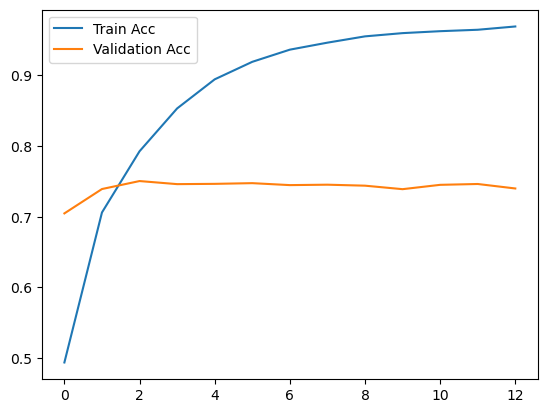

In [9]:
x = range(len(all_train_acc))

plt.plot(x, all_train_acc, label="Train Acc")
plt.plot(x, all_val_acc, label="Validation Acc")
plt.legend()
plt.show()

### Save Model

In [10]:
with open("My_ResNet50_Food.pickle", "wb") as f:
    pickle.dump(model.cpu(), f)

# Extract Embeddings, Prediction, labels and masks

### Load Model

In [3]:
with open("My_ResNet50_Food.pickle", "rb") as f:
    model = pickle.load(f)

In [4]:
def capture_embedding(layer, inp, out):
    embedding.append(out)
    
model.fc[0].register_forward_hook(capture_embedding)

### Extraction Pipeline

In [37]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
embedding, prediction_soft, prediction_hard, label = [], [], [], []

model.cuda()
model.eval()

print("Saving Training Data.")
for feat, labels in tqdm(train_dataloader, file=sys.stdout, ascii=" >="):
    with torch.no_grad():
        feat = feat.to(device)
        labels = labels.to(device)
        logits = model(feat)
        _, out = torch.max(logits, dim=1)
        prediction_soft.append(logits)
        prediction_hard.append(out)
        label.append(labels)
        
print("Saving Validation Data.")
for feat, labels in tqdm(val_dataloader, file=sys.stdout, ascii=" >="):
    with torch.no_grad():
        feat = feat.to(device)
        labels = labels.to(device)
        logits = model(feat)
        _, out = torch.max(logits, dim=1)
        prediction_soft.append(logits)
        prediction_hard.append(out)
        label.append(labels)
        
print("Saving Testing Data.")
for feat, labels in tqdm(test_dataloader, file=sys.stdout, ascii=" >="):
    with torch.no_grad():
        feat = feat.to(device)
        labels = labels.to(device)
        logits = model(feat)
        _, out = torch.max(logits, dim=1)
        prediction_soft.append(logits)
        prediction_hard.append(out)
        label.append(labels)

len_train, len_test, len_val = len(trainset), len(testset), len(valset)
total = len_train + len_test + len_val

train_mask = torch.tensor([True] * len_train + [False] * len_val + [False] * len_test)
test_mask =  torch.tensor([False] * len_train + [False] * len_val + [True] * len_test)
val_mask =   torch.tensor([False] * len_train + [True] * len_val + [False] * len_test)

embedding = torch.cat(embedding).cpu()
prediction_soft = torch.cat(prediction_soft).cpu()
prediction_soft = torch.softmax(prediction_soft, dim=1)
prediction_hard = torch.cat(prediction_hard).cpu()
label = torch.cat(label).cpu()

data = {
    "embeddings" : embedding,
    "y_soft" : prediction_soft,
    "y_hard" : prediction_hard,
    "labels" : label,
    "train_mask" : train_mask,
    "test_mask" : test_mask,
    "val_mask" : val_mask
}

with open("Data_ResNet50_Food.pickle", "wb") as f:
    pickle.dump(data, f)
    
print("All data dumped successfully.")

Saving Training Data.
100%|==================================================================================================================================================================| 4419/4419 [01:11<00:00, 61.44it/s]
Saving Validation Data.
100%|======================================================================================================================================================================| 79/79 [00:05<00:00, 13.41it/s]
Saving Testing Data.
100%|====================================================================================================================================================================| 395/395 [00:24<00:00, 16.22it/s]
All data dumped successfully.


# Create augmented graph

### Load Data

In [38]:
with open("Data_ResNet50_Food.pickle", "rb") as f:
    data = pickle.load(f)

In [39]:
embedding = data["embeddings"]
pred_soft = data["y_soft"]
pred_hard = data["y_hard"]
label = data["labels"]
train_mask = data["train_mask"]
test_mask = data["test_mask"]
val_mask = data["val_mask"]

### Graph Augmentation

In [40]:
from pynndescent import NNDescent

In [41]:
%%time

tree = NNDescent(embedding)
neighbours, _ = tree.query(embedding, k=16)
neighbours.shape

CPU times: user 2min 38s, sys: 13.1 s, total: 2min 51s
Wall time: 24.2 s


(101000, 16)

In [42]:
src = torch.arange(0, 101_000).reshape(-1, 1).repeat((1, 15)).flatten().numpy()
dst = neighbours[:, 1:].flatten()
src.shape, dst.shape

((1515000,), (1515000,))

In [43]:
graph = dgl.graph((src, dst), num_nodes=101_000)
graph = dgl.add_self_loop(graph)
graph.ndata["feat"] = embedding
graph.ndata["label"] = label
graph.ndata["train_mask"] = train_mask
graph.ndata["val_mask"] = val_mask
graph.ndata["test_mask"] = test_mask
graph.ndata["y_soft"] = pred_soft
graph.ndata["y_hard"] = pred_hard
graph

Graph(num_nodes=101000, num_edges=1616000,
      ndata_schemes={'feat': Scheme(shape=(512,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'y_soft': Scheme(shape=(101,), dtype=torch.float32), 'y_hard': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={})

### Save Graph

In [44]:
with open("Graph_ResNet50_Food.pickle", "wb") as f:
    pickle.dump(graph, f)

# Apply Correct and Smooth

### Code Files

`main.py`
```python
import os
import dgl
import copy
import torch
import pickle
import argparse
import torch.optim as optim
import torch.nn.functional as F
from model import CorrectAndSmooth
from ogb.nodeproppred import DglNodePropPredDataset, Evaluator


def evaluate(y_pred, y_true, mask):
    a = y_pred[mask].flatten()
    b = y_true[mask].flatten()
    return torch.sum(a == b) / len(a)


def main():
    # check cuda
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    
    with open("Graph_ResNet50_Food.pickle", "rb") as f:
        g = pickle.load(f)

    feat = g.ndata["feat"]
    labels = g.ndata["label"]
    feat = (feat - feat.mean(0)) / feat.std(0)
    g.ndata["feat"] = feat
    g = g.to(device)
    feats = g.ndata["feat"]
    labels = labels.to(device)
    train_mask = g.ndata["train_mask"].to(device)
    val_mask = g.ndata["val_mask"].to(device)
    test_mask = g.ndata["test_mask"].to(device)
    n_features = feats.shape[1]
    n_classes = 101
    y_soft = g.ndata["y_soft"]
    y_pred = g.ndata["y_hard"]

    print("--------------- Before ------------------")
    valid_acc = evaluate(y_pred, labels, val_mask)
    test_acc = evaluate(y_pred, labels, test_mask)
    print(f"Valid acc: {valid_acc:.4f} | Test acc: {test_acc:.4f}")
    
    
    print("---------- Correct & Smoothing ----------")
    cs = CorrectAndSmooth(
        num_correction_layers=args.num_correction_layers,
        correction_alpha=args.correction_alpha,
        correction_adj=args.correction_adj,
        num_smoothing_layers=args.num_smoothing_layers,
        smoothing_alpha=args.smoothing_alpha,
        smoothing_adj=args.smoothing_adj,
        autoscale=args.autoscale,
        scale=args.scale,
    )

    y_soft = cs.correct(g, y_soft, labels[train_mask], train_mask)
    y_soft = cs.smooth(g, y_soft, labels[train_mask], train_mask)
    y_pred = y_soft.argmax(dim=-1, keepdim=True)
    valid_acc = evaluate(y_pred, labels, val_mask)
    test_acc = evaluate(y_pred, labels, test_mask)
    print(f"Valid acc: {valid_acc:.4f} | Test acc: {test_acc:.4f}")


if __name__ == "__main__":
    """
    Correct & Smoothing Hyperparameters
    """
    parser = argparse.ArgumentParser(description="Base predictor(C&S)")
    # C & S
    parser.add_argument("--num-correction-layers", type=int, default=50)
    parser.add_argument("--correction-alpha", type=float, default=0.979)
    parser.add_argument("--correction-adj", type=str, default="DAD")
    parser.add_argument("--num-smoothing-layers", type=int, default=50)
    parser.add_argument("--smoothing-alpha", type=float, default=0.756)
    parser.add_argument("--smoothing-adj", type=str, default="DAD")
    parser.add_argument("--autoscale", action="store_true")
    parser.add_argument("--scale", type=float, default=20.0)

    args = parser.parse_args()
    # print(args)

    main()
```

`model.py`
```python
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl.function as fn


class LabelPropagation(nn.Module):
    def __init__(self, num_layers, alpha, adj="DAD"):
        super(LabelPropagation, self).__init__()

        self.num_layers = num_layers
        self.alpha = alpha
        self.adj = adj

    @torch.no_grad()
    def forward(self, g, labels, mask=None, post_step=lambda y: y.clamp_(0.0, 1.0)):
        with g.local_scope():
            if labels.dtype == torch.long:
                labels = F.one_hot(labels.view(-1)).to(torch.float32)

            y = labels
            if mask is not None:
                y = torch.zeros_like(labels)
                y[mask] = labels[mask]

            last = (1 - self.alpha) * y
            degs = g.in_degrees().float().clamp(min=1)
            norm = (torch.pow(degs, -0.5 if self.adj == "DAD" else -1).to(labels.device).unsqueeze(1))

            for _ in range(self.num_layers):
                # Assume the graphs to be undirected
                if self.adj in ["DAD", "AD"]: y = norm * y
                g.ndata["h"] = y
                g.update_all(fn.copy_u("h", "m"), fn.sum("m", "h"))
                y = self.alpha * g.ndata.pop("h")
                if self.adj in ["DAD", "DA"]:y = y * norm
                y = post_step(last + y)

            return y


class CorrectAndSmooth(nn.Module):
    def __init__(
        self,
        num_correction_layers,
        correction_alpha,
        correction_adj,
        num_smoothing_layers,
        smoothing_alpha,
        smoothing_adj,
        autoscale=True,
        scale=1.0,
    ):
        super(CorrectAndSmooth, self).__init__()
        self.autoscale = autoscale
        self.scale = scale
        self.prop1 = LabelPropagation(num_correction_layers, correction_alpha, correction_adj)
        self.prop2 = LabelPropagation(num_smoothing_layers, smoothing_alpha, smoothing_adj)

    def correct(self, g, y_soft, y_true, mask):
        with g.local_scope():
            assert abs(float(y_soft.sum()) / y_soft.size(0) - 1.0) < 1e-2
            numel = (int(mask.sum()) if mask.dtype == torch.bool else mask.size(0))
            assert y_true.size(0) == numel

            if y_true.dtype == torch.long:
                y_true = F.one_hot(y_true.view(-1), y_soft.size(-1)).to(y_soft.dtype)

            error = torch.zeros_like(y_soft)
            error[mask] = y_true - y_soft[mask]

            if self.autoscale:
                smoothed_error = self.prop1(g, error, post_step=lambda x: x.clamp_(-1.0, 1.0))
                sigma = error[mask].abs().sum() / numel
                scale = sigma / smoothed_error.abs().sum(dim=1, keepdim=True)
                scale[scale.isinf() | (scale > 1000)] = 1.0

                result = y_soft + scale * smoothed_error
                result[result.isnan()] = y_soft[result.isnan()]
                return result
            else:
                def fix_input(x):
                    x[mask] = error[mask]
                    return x

                smoothed_error = self.prop1(g, error, post_step=fix_input)
                result = y_soft + self.scale * smoothed_error
                result[result.isnan()] = y_soft[result.isnan()]
                return result

    def smooth(self, g, y_soft, y_true, mask):
        with g.local_scope():
            numel = (int(mask.sum()) if mask.dtype == torch.bool else mask.size(0))
            assert y_true.size(0) == numel

            if y_true.dtype == torch.long:
                y_true = F.one_hot(y_true.view(-1), y_soft.size(-1)).to(y_soft.dtype)

            y_soft[mask] = y_true
            return self.prop2(g, y_soft)

```

### Run

In [60]:
!python3 main.py

--------------- Before ------------------
Valid acc: 0.7505 | Test acc: 0.7966
---------- Correct & Smoothing ----------
Valid acc: 0.6552 | Test acc: 0.6926
